In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

import numpy as np
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/satellite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vectorize texts via tf_idf vectorizer

In [2]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [3]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
vectorizer = TfidfVectorizer(stop_words=russian_stopwords, preprocessor=preprocess_text)

Load train data and fit vectorizer

In [4]:
df = pd.read_parquet('data/train.parquet')
X = df['question'].to_numpy()
y = df.drop('question', axis=1).to_numpy()

In [6]:
X = vectorizer.fit_transform(X)

Train logistic regression

In [10]:
import pickle

with open('data/label_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

In [16]:
labels = np.argmax(y, axis=1)
lr = LogisticRegression(random_state=0).fit(X, labels)

Watch model's perfomance on the test data

In [17]:
df = pd.read_parquet('data/test.parquet')
X_test = df['question'].to_numpy()
y_test = df.drop('question', axis=1).to_numpy()

In [18]:
X_test = vectorizer.transform(X_test)
preds = lr.predict_proba(X_test)
roc_auc_score(y_test, preds, average='macro', multi_class='ovo')

0.9926058213057012

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1), lr.predict(X_test), normalize='true')
sorting_idx = np.argsort(np.diag(cm))[::-1]
sorted_cm = cm[sorting_idx,:][:,sorting_idx]
annos = df.columns[1:]
sorted_annos = []
for id in sorting_idx:
  sorted_annos.append(annos[id])

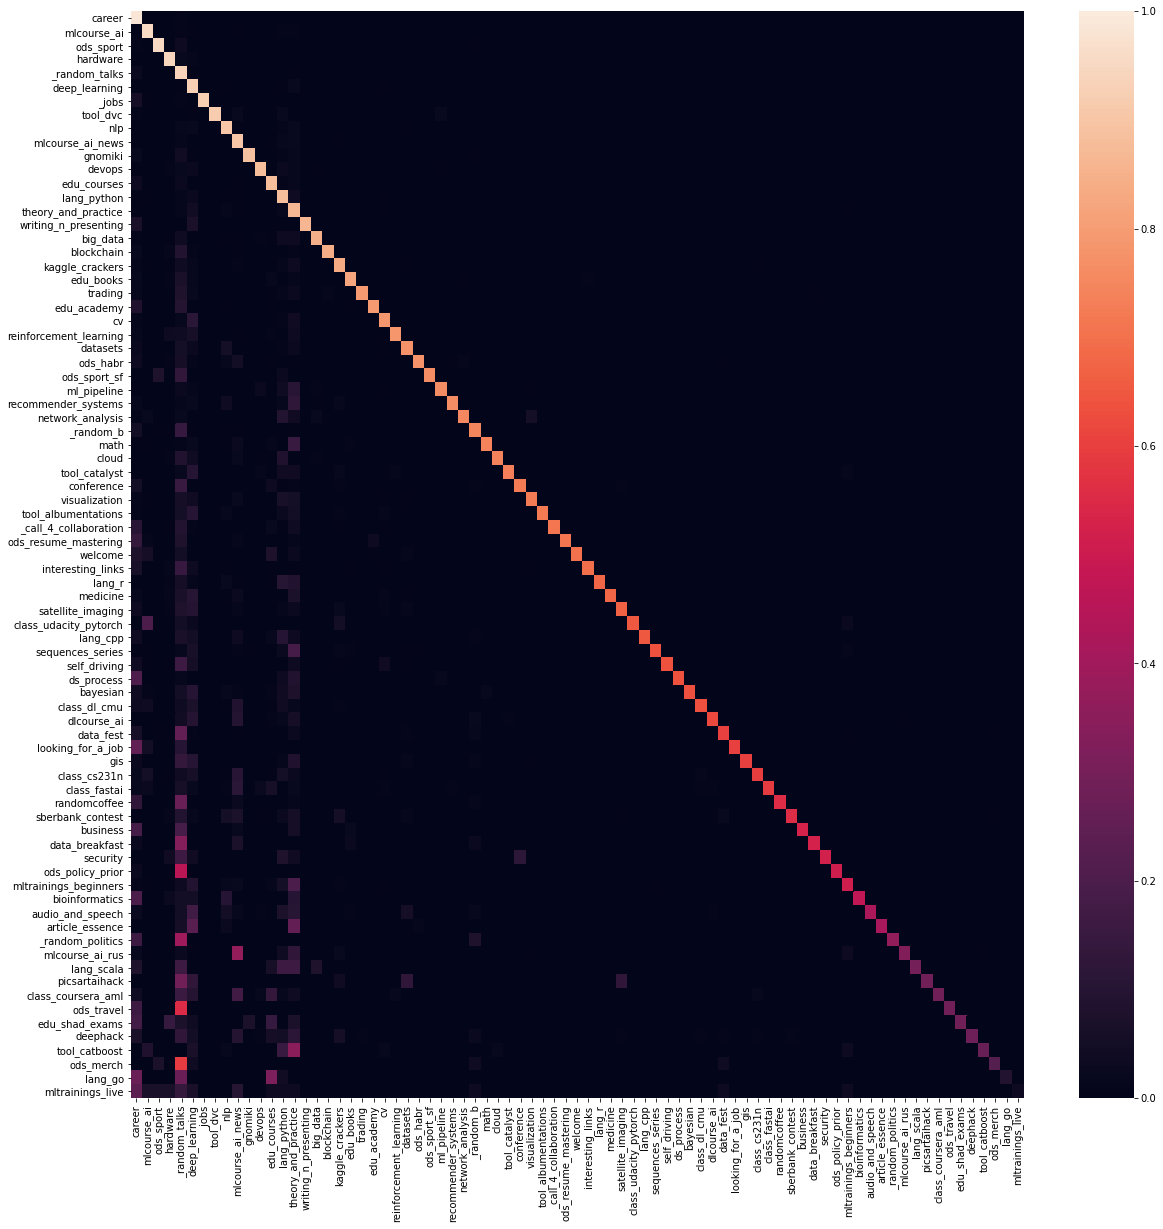

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(sorted_cm, vmax=1, xticklabels=sorted_annos, yticklabels=sorted_annos)

In [22]:
fig.savefig('plots/tfidf_logreg_heatmap.svg')